# Lab session 3 ---- Linear Classification

Student: ASRAF ALI Abdul Salam Rasmi                       
Date: 19/05/2019

## I. Introduction
In this lab, we will implement linear discriminant analysis and logistic regression.
We will try to recognize images.
You shall submit a clearly written and commented report as well as your own code.

In [1]:
# Import Essential Libraries

# To deal with Arrays
import numpy as np

# To Plot Graph and Show Figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# To Supress Warnings (Optional)
import warnings
warnings.filterwarnings('ignore')

# To Load MATLAB Files
from scipy.io import loadmat

# To Perform Optimization
from scipy.optimize import minimize

## II. Female or Male?
The file heightWeightData.txt contains some data showing the height and weight of different people. The first column is the class label (1=male, 2=female), the second column is the height and the third is the weight.

## Question 1
Extract the height/weight data corresponding to males. 

In [2]:
# To Plot Covariance Ellipse (Found on: http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/)

def plot_cov_ellipse(cov, pos, volume=.5, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an ellipse enclosing *volume* based on the specified covariance
    matrix (*cov*) and location (*pos*). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        volume : The volume inside the ellipse; defaults to 0.5
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
    """
    # Libraries to Plot Ellipse
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)

In [3]:
# Read the Data
data = np.loadtxt("heightWeightData.txt", delimiter= ",")
X = data[:,1:3]
y = data[:,0]

# Extract Rows containing Data of Males (label = 1)
labels = data[:,0]
idx_male = (labels == 1)

X_male = data[idx_male,1:3]

# Mean of Male Heights and Weights
mean_male = np.mean(X_male, 0)

# Covariance of Male Height and Weight
from numpy.matlib import repmat # Library to Replicate an Array into Matrix
X_meanCentered = X_male - repmat(mean_male, np.size(X_male, 0), 1)
cov_male = np.cov(X_male.T)

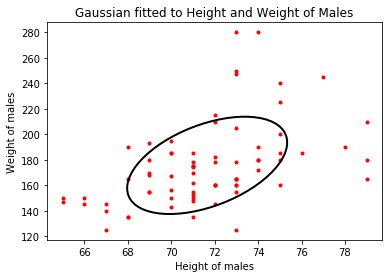

In [4]:
# Visualizing Male Data
gaussianSamples = np.random.multivariate_normal(mean_male, cov_male, 1000)

pdata = plt.scatter(X_male[:,0], X_male[:,1], color = 'r', marker = '.')
pdatagauss = plot_cov_ellipse(cov_male, mean_male)

plt.xlabel('Height of males')
plt.ylabel('Weight of males')
plt.title('Gaussian fitted to Height and Weight of Males')

plt.show()

## Question 2 
Standardize the data (i.e. make each feature have 0 mean and unit variance) and re-estimate the
2d Gaussian.

In [5]:
# Normalization
X_normalized = np.column_stack([X_meanCentered[:,0]*1./cov_male[0,0], X_meanCentered[:,1]*1./cov_male[1,1]]) 
mean_male_normalized = np.mean(X_normalized, 0)
cov_male_normalized = np.cov(X_normalized.T)

## Question 3
data whitening or sphering

In [6]:
# Data Whitening

# Estimate Dominant Eigenvectors of Data
cov_male_centered = np.cov(X_meanCentered.T)
evals, evecs = np.linalg.eigh(cov_male_centered)
order = evals.argsort()[::-1]
evals = evals[order]
evecs = evecs[:,order]

# Project Data along the Dominant Eigenvectors 
X_whitened = np.dot(np.diag(1./evals), np.dot(evecs.T, X_meanCentered.T))
X_whitened = X_whitened.T

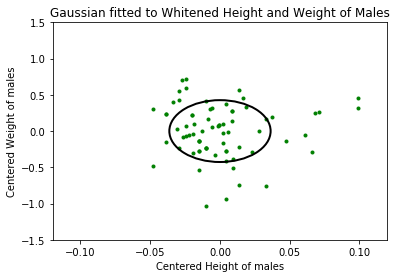

[[ 9.50724221e-04 -2.09612420e-18]
 [-2.09612420e-18  1.31396910e-01]]


In [7]:
# Visualizing Male Data after Normalization
mean_male_whitened = np.mean(X_whitened, 0)
cov_male_whitened = np.cov(X_whitened.T)

plt.scatter(X_whitened[:,0], X_whitened[:,1], color = 'g', marker = '.')
plot_cov_ellipse(cov_male_whitened, mean_male_whitened)

plt.xlabel('Centered Height of males')
plt.ylabel('Centered Weight of males')
plt.title('Gaussian fitted to Whitened Height and Weight of Males')
plt.xlim([-0.12, 0.12])
plt.ylim([-1.5, 1.5])

plt.show()

print(cov_male_whitened)

### We now want to use the height/weight features to classify each person as male or female.


## Question 1
Use LDA to perform this classification and compute the training error. Note that we will use all data as training set.

In [8]:
# Library to Perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create a Model
lda = LinearDiscriminantAnalysis()

# Fit the Model for given Data
lda.fit(X,y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [9]:
# Calculate Training Accuracy
print("Training Accuracy:",(lda.score(X,y.ravel()))*100,"%")

Training Accuracy: 88.09523809523809 %


## Question 2
We can also use PCA to project the data onto a 1d space. Compute the corresponding principal component and explain the difference with the decision boundary found by LDA?

In [10]:
# Libraries to Perform PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the Features
X_std = StandardScaler().fit_transform(X)

# Create a Model
pca = PCA(n_components=1)

# Fit the Model for given Data
X_pca = pca.fit_transform(X_std)

In [11]:
# Create a Model
lda1 = LinearDiscriminantAnalysis()

# Fit the Model for Transformed Data
lda1.fit(X_pca,y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [12]:
# Calculate Training Accuracy for Transformed Data
print("Training Accuracy:",(lda1.score(X_pca,y.ravel()))*100,"%")

Training Accuracy: 88.57142857142857 %


##### The dimensionality reduction using PCA didnot affect the data accuracy much but will decrease the computational time to an extent.

## III. Digits recognition

## Question 1
### Data visualization

In [13]:
# Load the Training Data
data_train = loadmat('trainingData.mat')
data_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'training', 'trainingLabels'])

In [14]:
# Split the Data and Labels
y_train = data_train['trainingLabels']
X_train = data_train['training']
print('X: {}'.format(X_train.shape))
print('y: {}'.format(y_train.shape))

X: (8000, 784)
y: (8000, 1)


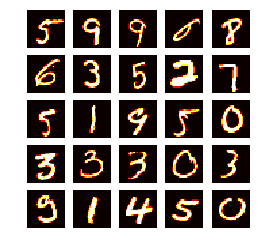

In [15]:
# Show some Digits from Training Data
fig, axis = plt.subplots(5,5,figsize=(4,4))
for i in range(5):
    for j in range(5):
        axis[i,j].imshow((X_train[np.random.randint(0,8000),:].reshape(28,28,order="F")).T, cmap="hot")
        axis[i,j].axis("off")

In [16]:
# Load the Test Data
data_test = loadmat('testData.mat')
data_test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test', 'testLabels'])

In [17]:
# Split the Data and Labels
y_test = data_test['testLabels']
X_test = data_test['test']
print('X: {}'.format(X_test.shape))
print('y: {}'.format(y_test.shape))

X: (2000, 784)
y: (2000, 1)


## Question 2
### Dimension reduction (using PCA)

In [18]:
# Standardizing the Features
X_STD = np.r_[X_train,X_test] # Merge both Training and Test Data
X_STD = StandardScaler().fit_transform(X_STD)

In [19]:
# Create a Model
pca = PCA(n_components=2) # Reduce the dimension of data, keeping only the first two principal components (d=2)

# Transform the Data
X_PCA = pca.fit_transform(X_STD)

In [20]:
# Split the Training and Test Data
X_PCA_train = X_PCA[0:X_train.shape[0],:]
X_PCA_test = X_PCA[X_train.shape[0]:X_PCA.shape[0],:]

## Question 3
### A - Classification without Dimension Reduction

### (i) Logistic Regression

In [21]:
# Library to Perform Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create a Model
lr = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the Model for given Data
lr.fit(X_train,y_train.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Calculate Training Accuracy
pred = lr.predict(X_train)
print('Training Accuracy: {} %'.format(np.mean(pred == y_train.ravel())*100))

Training Accuracy: 99.6125 %


In [23]:
# Calculate Test Accuracy
pred = lr.predict(X_test)
print('Test Accuracy: {} %'.format(np.mean(pred == y_test.ravel())*100))

Test Accuracy: 86.45 %


### (ii) Support Vector Machine

In [24]:
# Library to Perform SVM
from sklearn.svm import LinearSVC

# Create a Model
svm = LinearSVC()

# Fit the Model for given Data
svm.fit(X_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
# Calculate Training Accuracy
print("Training Accuracy:",(svm.score(X_train,y_train.ravel()))*100,"%")

Training Accuracy: 96.5375 %


In [26]:
# Calculate Test Accuracy
print("Test Accuracy:",(svm.score(X_test,y_test.ravel()))*100,"%")

Test Accuracy: 87.2 %


### B - Classification with Dimension Reduction

### (i) Logistic Regression

In [27]:
# Create a Model
lr_pca = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the Model for given Data
lr_pca.fit(X_PCA_train,y_train.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# Calculate Training Accuracy
pred = lr_pca.predict(X_PCA_train)
print('Training Accuracy: {} %'.format(np.mean(pred == y_train.ravel())*100))

Training Accuracy: 39.85 %


In [29]:
# Calculate Test Accuracy
pred = lr_pca.predict(X_PCA_test)
print('Test Accuracy: {} %'.format(np.mean(pred == y_test.ravel())*100))

Test Accuracy: 45.4 %


### (ii) Support Vector Machine

In [30]:
# Create a Model
svm_pca = LinearSVC()

# Fit the Model for given Data
svm_pca.fit(X_PCA_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
# Calculate Training Accuracy
print("Training Accuracy:",(svm_pca.score(X_PCA_train,y_train.ravel()))*100,"%")

Training Accuracy: 36.475 %


In [32]:
# Calculate Test Accuracy
print("Test Accuracy:",(svm_pca.score(X_PCA_test,y_test.ravel()))*100,"%")

Test Accuracy: 42.95 %


## Question 4
We have reduced the dimesion to 2, but this was an arbitrary choice.

##### As we can see from the Result, Training and Test Accuracy has decreased drastically when we have reduced the dimentionality from "784-D" to "2-D" using PCA.

How can we select a better value for d?

##### For selecting the better value for 'd' we need to consider the minimum number of Principal Componenets which gives better accuracy on both training and test data. Some Examples are shown below. 

### 1. For d = 70

In [33]:
# Create a Model
pca = PCA(n_components=70) # Reduce the dimension of data, keeping only the first 70 principal components (d=70)

# Transform the Data
X_PCA = pca.fit_transform(X_STD)

In [34]:
# Split the Training and Test Data
X_PCA_train = X_PCA[0:X_train.shape[0],:]
X_PCA_test = X_PCA[X_train.shape[0]:X_PCA.shape[0],:]

### (i) Logistic Regression

In [35]:
# Create a Model
lr_pca = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the Model for given Data
lr_pca.fit(X_PCA_train,y_train.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
# Calculate Training Accuracy
pred = lr_pca.predict(X_PCA_train)
print('Training Accuracy: {} %'.format(np.mean(pred == y_train.ravel())*100))

Training Accuracy: 91.125 %


In [37]:
# Calculate Test Accuracy
pred = lr_pca.predict(X_PCA_test)
print('Test Accuracy: {} %'.format(np.mean(pred == y_test.ravel())*100))

Test Accuracy: 91.25 %


### (ii) Support Vector Machine

In [38]:
# Create a Model
svm_pca = LinearSVC()

# Fit the Model for given Data
svm_pca.fit(X_PCA_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [39]:
# Calculate Training Accuracy
print("Training Accuracy:",(svm_pca.score(X_PCA_train,y_train.ravel()))*100,"%")

Training Accuracy: 90.35 %


In [40]:
# Calculate Test Accuracy
print("Test Accuracy:",(svm_pca.score(X_PCA_test,y_test.ravel()))*100,"%")

Test Accuracy: 91.10000000000001 %


### 2. For d = 100

In [41]:
# Create a Model
pca = PCA(n_components=100) # Reduce the dimension of data, keeping only the first 100 principal components (d=100)

# Transform the Data
X_PCA = pca.fit_transform(X_STD)

In [42]:
# Split the Training and Test Data
X_PCA_train = X_PCA[0:X_train.shape[0],:]
X_PCA_test = X_PCA[X_train.shape[0]:X_PCA.shape[0],:]

### (i) Logistic Regression

In [43]:
# Create a Model
lr_pca = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the Model for given Data
lr_pca.fit(X_PCA_train,y_train.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
# Calculate Training Accuracy
pred = lr_pca.predict(X_PCA_train)
print('Training Accuracy: {} %'.format(np.mean(pred == y_train.ravel())*100))

Training Accuracy: 92.07499999999999 %


In [45]:
# Calculate Test Accuracy
pred = lr_pca.predict(X_PCA_test)
print('Test Accuracy: {} %'.format(np.mean(pred == y_test.ravel())*100))

Test Accuracy: 92.10000000000001 %


### (ii) Support Vector Machine

In [46]:
# Create a Model
svm_pca = LinearSVC()

# Fit the Model for given Data
svm_pca.fit(X_PCA_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [47]:
# Calculate Training Accuracy
print("Training Accuracy:",(svm_pca.score(X_PCA_train,y_train.ravel()))*100,"%")

Training Accuracy: 91.2875 %


In [48]:
# Calculate Test Accuracy
print("Test Accuracy:",(svm_pca.score(X_PCA_test,y_test.ravel()))*100,"%")

Test Accuracy: 91.45 %


### 3. For d = 200

In [49]:
# Create a Model
pca = PCA(n_components=200) # Reduce the dimension of data, keeping only the first 200 principal components (d=200)

# Transform the Data
X_PCA = pca.fit_transform(X_STD)

In [50]:
# Split the Training and Test Data
X_PCA_train = X_PCA[0:X_train.shape[0],:]
X_PCA_test = X_PCA[X_train.shape[0]:X_PCA.shape[0],:]

### (i) Logistic Regression

In [51]:
# Create a Model
lr_pca = LogisticRegression(C=10, penalty='l2', solver='liblinear')

# Fit the Model for given Data
lr_pca.fit(X_PCA_train,y_train.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
# Calculate Training Accuracy
pred = lr_pca.predict(X_PCA_train)
print('Training Accuracy: {} %'.format(np.mean(pred == y_train.ravel())*100))

Training Accuracy: 94.69999999999999 %


In [53]:
# Calculate Test Accuracy
pred = lr_pca.predict(X_PCA_test)
print('Test Accuracy: {} %'.format(np.mean(pred == y_test.ravel())*100))

Test Accuracy: 91.45 %


### (ii) Support Vector Machine

In [54]:
# Create a Model
svm_pca = LinearSVC()

# Fit the Model for given Data
svm_pca.fit(X_PCA_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [55]:
# Calculate Training Accuracy
print("Training Accuracy:",(svm_pca.score(X_PCA_train,y_train.ravel()))*100,"%")

Training Accuracy: 93.6875 %


In [56]:
# Calculate Test Accuracy
print("Test Accuracy:",(svm_pca.score(X_PCA_test,y_test.ravel()))*100,"%")

Test Accuracy: 90.8 %


##### From the results it is obvious that just with 70 Principal Components we can get better Classification accuracy. The test accuracy is actually greater than the results obtained without Dimensionality reduction. 